In [12]:
# #!/usr/bin/python


# | Authors:  | Bex Dunn|
# |----------|----------------|
# | Created: | Jan 7, 2019 |
# | Last edited: | Jan 22,2019 |


#  Before running this script load these modules:
# `module use /g/data/v10/public/modules/modulefiles` 
# `module load dea`
# This code is designed to run on raijin, on the Australian NCI. 
# The shell script to run this code has a *.sh extension


# If you find an error in this code, please raise an issue at https://github.com/GeoscienceAustralia/dea-notebooks
# 
# This code takes a supplied shapefile of a polygon and queries Digital Earth
# Australia http://geoscienceaustralia.github.io/digitalearthau/
# for WOfS, Fractional Cover and NBART. It calculates thresholded tasselled cap wetness. The dominant result for
# each pixel is calculated and the percentage area of the polygon covered by water, wet vegetation, 
# photosynthetic vegetation, non-photosynthetic vegetation and bare soil is output into a jpg stacked plot and to
# csv. The resulting data can be used to monitor changes in wetland behaviour spatiotemporally. 

# - Input Datasets:
# - Landsat 5
# - Landsat 7
# - Landsat 8

# -- Fractional Cover --
# - PV - Photosythetic vegetation
# - NPV - Non-Photosythetic vegetation
# - BS - Bare Soil

# - WOfS Feature Layers (WOFLs)

# __Future Work:__ 
# - do this by max extent of wetness
# - add rainfall for context -- waiting on an update as to availability of data        

### Import Statements: import the modules we need ------------------------------

import csv
import multiprocessing as mp

#$#$#$#$#$

import datacube
import datetime
import fiona
import geopandas as gpd
from math import ceil
import numpy as np
import pandas as pd
import rasterio.mask
import rasterio.features
from shapely import geometry
import seaborn as sns
import sys
import time
import xarray as xr

#keep the plotting modules in here as we want to output the stackplots to *.jpg
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

from datacube.storage import masking
from datacube.utils import geometry

#append path to dea notebooks scripts to the system so we can access it
sys.path.append('/g/data/r78/rjd547/jupyter_notebooks/dea-notebooks/10_Scripts')
import DEADataHandling, DEAPlotting, TasseledCapTools

# setup the datacube 
dc = datacube.Datacube(app='asset drill')

### Set up polygon
poly_path='/g/data/r78/rjd547/Ramsar_Wetlands/ExplodedRAMSAR.shp'
print(f'Shape file is {poly_path}')

#part = sys.argv[1] ###FIXME: update before running on raijin
part = 1
part = int(part)
print(f'system argument received is {part}')

global Output_dir
Output_dir = '/g/data/r78/rjd547/Ramsar_Wetlands/Ramsar_Outputs_1/'

# add in a delay between dc.load calls to avoid overloading the database - 5 seconds in this case
time.sleep(5*part)
#open the polygon

#this code tells us which polygon ids will be running on this particular (node?). Shapessubset will be the subset of polygons that our function
#will run over. ###FIXME - can we send this to some kind of multiprocessing?
with fiona.open(poly_path) as allshapes:
        #get the crs of the polygon file to use when processing each polygon
        crs = geometry.CRS(allshapes.crs_wkt)
        #get the list of all the shapes in the shapefile
        ShapesList = list(allshapes)
        #Desired number of chunks
        #Set this to 32 because we have 32 CPUs that we'd like to run across
        DesiredChunks = 32
        ChunkSize = ceil(len(ShapesList)/DesiredChunks) #this was set due to Claire having 64000 polygons in her code
        print(f'chunk size is {ChunkSize}')
        print(f'There are {int(len(ShapesList)/ChunkSize)} generated chunks')
        shapessubset = allshapes[(part - 1) * ChunkSize: part * ChunkSize]
        print(f'Running for polygon IDs in the range {(part - 1) * ChunkSize} to {part * ChunkSize}')  

Shape file is /g/data/r78/rjd547/Ramsar_Wetlands/ExplodedRAMSAR.shp
system argument received is 1
chunk size is 9
There are 30 generated chunks
Running for polygon IDs in the range 0 to 9


### define functions that are run in the mainline here

In [56]:
def get_RAMSAR_polyName(shapefile):
    ''' function designed specifically for the RAMSAR wetlands australia shapefile. Takes the shapefile and extracts
    the ramsar name, wetland name and objectID from the ESRI shapefile format and turns it into a useful string for our output.
    :Inputs: shapefile with RAMSAR_NAM, WETLAND_NA, and OBJECTID as properties. 
    Author: Bex Dunn Last Edited: March 2019'''
    # get the ramsar name from the shapes 
    RAMSAR_NAME = '_'.join(shapefile['properties']['RAMSAR_NAM'].split(' '))
    WETLAND_NAME = '_'.join(shapefile['properties']['WETLAND_NA'].split(' '))
    STATE = '_'.join(shapefile['properties']['STATE'].split(' ')) 
    ID = shapefile['id']
    polyName = f'{RAMSAR_NAME}-{WETLAND_NAME}-{STATE}-{ID}'
    print(f'processing polygon {polyName}')
    return(polyName)

In [57]:
def BigFunkyFunction(lilshape):
    '''This is a function that does lots of things. It takes a single polygon and  '''
    ### This is set up to be shapefile-specific. I'm not sure this can be avoided, as often shapefiles are pretty specific..
    first_geometry = lilshape['geometry']
    polyName = get_RAMSAR_polyName(lilshape)
    geom = geometry.Geometry(first_geometry, crs=crs)
    query = {'geopolygon': geom}# this should run for all time, if there is no time set?
    print(polyName,query)
    
    

In [58]:
testin = gpd.read_file(poly_path)

In [59]:
for shape in shapessubset:
    first_geometry = shape['geometry']
    polyName = get_RAMSAR_polyName(shape)
    geom = geometry.Geometry(first_geometry, crs=crs)
    query = {'geopolygon': geom}# this should run for all time, if there is no time set?

processing polygon Cobourg_Peninsula-Cobourg_Peninsula-NT-0
processing polygon Cobourg_Peninsula-Cobourg_Peninsula-NT-1
processing polygon Cobourg_Peninsula-Cobourg_Peninsula-NT-2
processing polygon Cobourg_Peninsula-Cobourg_Peninsula-NT-3
processing polygon Cobourg_Peninsula-Cobourg_Peninsula-NT-4
processing polygon Cobourg_Peninsula-Cobourg_Peninsula-NT-5
processing polygon Cobourg_Peninsula-Cobourg_Peninsula-NT-6
processing polygon Cobourg_Peninsula-Cobourg_Peninsula-NT-7
processing polygon Cobourg_Peninsula-Cobourg_Peninsula-NT-8


In [64]:
def BigFunkyFunction(lilshape,crs):
    '''This is a function that does lots of things. It takes a single polygon and  '''
    ### This is set up to be shapefile-specific. I'm not sure this can be avoided, as often shapefiles are pretty specific..
    first_geometry = lilshape['geometry']
    polyName = get_RAMSAR_polyName(lilshape)
    geom = geometry.Geometry(first_geometry, crs=crs)
    query = {'geopolygon': geom}# this should run for all time, if there is no time set?
    
    ## Set up datasets
    #set cloudmasking threshold and load landsat nbart data
    landsat_masked_prop = 0.90
    ls578_ds = DEADataHandling.load_clearlandsat(dc=dc, query=query, product='nbart',
            masked_prop=landsat_masked_prop)

    ### mask the data with our original polygon to remove extra data 

    data = ls578_ds
    mask = rasterio.features.geometry_mask([geom.to_crs(data.geobox.crs)for geoms in [geom]],
                                               out_shape=data.geobox.shape,
                                               transform=data.geobox.affine,
                                               all_touched=False,
                                               invert=False)

    #for some reason xarray is not playing nicely with our old masking function
    mask_xr = xr.DataArray(mask, dims = ('y','x'))
    ls578_ds = data.where(mask_xr==False)

    #transform the nbart into tci
    tci = TasseledCapTools.thresholded_tasseled_cap(ls578_ds,wetness_threshold=-350, drop=True , drop_tc_bands=True)

    ### create a masked version of the extent of overthreshold wetness

    #select only finite values (over threshold values)
    tcw = xr.ufuncs.isfinite(tci.wetness_thresholded)

    # #reapply the polygon mask
    tcw = tcw.where(mask_xr==False)

    ### load wofls and select only wet pixels

    #load wofs
    wofls = dc.load(product = 'wofs_albers', like=ls578_ds)

    #only get wet obs
    wetwofl = masking.make_mask(wofls, wet=True)

    #match the wofs observations to the nbart
    wetwofl=wetwofl.where(wofls.time==ls578_ds.time)

    ### mask the wofs obs

    #mask the wofs obs with the polygon mask
    wetwofl = wetwofl.where(mask_xr==False)

    ### load in fractional cover data

    #load the data according to our query
    #choose a mask proportion to look for a clear timestep
    fc_ds = DEADataHandling.load_clearlandsat(dc, query,product='fc',masked_prop=0.90)

    ### mask FC with polygon

    fc_ds = fc_ds.where(mask_xr==False)

    ### mask FC with wetness

    fc_ds_noTCW=fc_ds.where(tcw==False)

    ### Calculate number of pixels in area of interest

    #number of pixels in area of interest
    pixels = (mask_xr==0).sum(dim=['x','y'])

    mask_xr==0
    mask_xr.count(dim=['x','y'])

    #count number of wofs pixels
    wofs_pixels = wetwofl.water.sum(dim=['x','y'])

    #count percentage of area of wofs
    wofs_area_percent = (wofs_pixels/pixels)*100

    #count number of tcw pixels
    tcw_pixel_count = tcw.sum(dim=['x','y'])

    #calculate percentage area wet
    tcw_area_percent = (tcw_pixel_count/pixels)*100

    #calculate wet not wofs
    tcw_less_wofs = tcw_area_percent-wofs_area_percent

    ### Calculate the dominant fraction for each pixel in Fractional Cover

    #drop data percentage and Unmixing Error
    fc_tester = fc_ds_noTCW.drop(['data_perc','UE'])

    #following robbi's advice, cast the dataset to a dataarray
    maxFC = fc_tester.to_array(dim='variable', name='maxFC')

    #turn FC array into integer only as nanargmax doesn't seem to handle floats the way we want it to
    FC_int = maxFC.astype('int8')

    #use numpy.nanargmax to get the index of the maximum value along the variable dimension
    #BSPVNPV=np.nanargmax(FC_int, axis=0)
    BSPVNPV=FC_int.argmax(dim='variable')

    FC_mask=xr.ufuncs.isfinite(maxFC).all(dim='variable')

    # #re-mask with nans to remove no-data
    BSPVNPV=BSPVNPV.where(FC_mask)


    FC_dominant = xr.Dataset({
        'BS': (BSPVNPV==0).where(FC_mask),
        'PV': (BSPVNPV==1).where(FC_mask),
        'NPV': (BSPVNPV==2).where(FC_mask),
    })

    FC_count = FC_dominant.sum(dim=['x','y'])

    #Fractional cover pixel count method
    #Get number of FC pixels, divide by total number of pixels per polygon

    Bare_soil_percent=(FC_count.BS/pixels)*100

    Photosynthetic_veg_percent=(FC_count.PV/pixels)*100

    NonPhotosynthetic_veg_percent=(FC_count.NPV/pixels)*100

    NoData = 100 - wofs_area_percent- tcw_less_wofs - Photosynthetic_veg_percent - NonPhotosynthetic_veg_percent - Bare_soil_percent

    query['time'][0]

    #set up color palette
    pal = [sns.xkcd_rgb["cobalt blue"],
           sns.xkcd_rgb["neon blue"],
           sns.xkcd_rgb["grass"],
           sns.xkcd_rgb["beige"],
           sns.xkcd_rgb["brown"]]#,
          #sns.xkcd_rgb["grey"]]

    #make a stacked area plot
    plt.clf()
    plt.figure(figsize = (12,6))
    plt.stackplot(wofs_area_percent.time.values, 
                  wofs_area_percent, 
                  tcw_less_wofs, 
                  Photosynthetic_veg_percent, 
                  NonPhotosynthetic_veg_percent,
                  Bare_soil_percent,
                  NoData,
                  labels=['open water',
                          'wet',
                          'PV',
                          'NPV',
                          'BS'#,
                          #'NoData'
                         ], colors=pal, alpha = 0.6)

    plt.title('Percentage of area WOfS, Wetness, Fractional Cover')

    #set axis limits to the min and max
    plt.axis(xmin = query['time'][0], xmax = query['time'][1], ymin = 0, ymax = 100)

    #set date ticks every year
    years = mdates.YearLocator(2)
    yearsFmt = mdates.DateFormatter('%Y')
    ax = plt.gca()
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(yearsFmt)

    #add a legend and a tight plot box
    plt.legend(loc='upper right')
    plt.tight_layout()

    #save the figure
    plt.savefig(f'{Output_dir}{polyName}.png')#, transparent=True)

In [65]:
print(f'{Output_dir}{polyName}.png')

/g/data/r78/rjd547/Ramsar_Wetlands/Ramsar_Outputs_1/Cobourg_Peninsula-Cobourg_Peninsula-NT-8.png


### FIXME : replace with correct function

In [ ]:
  #-----------------------------------------------------------------------#

# Launch a process for each polygon.

### for each shapefile in our subset of shapefiles:
for shapes in shapessubset:
    ### try to run the function once, for the shapefile and given crs
    result = BigFunkyFunction(shapes, crs)
    ### if result is False ie. doesn't run
    if not result: 
        ### Try to run the function again
        result = BigFunkyFunction(shapes, crs)
    ### if that didn't work:    
    if not result:
        ### try for a third and last time
        result = BigFunkyFunction(shapes, crs)   

processing polygon Cobourg_Peninsula-Cobourg_Peninsula-NT-0
Loading ls5


### FIXME Holding pen for geometry munging work

In [ ]:
with fiona.open(poly_path) as shapes:
#     crs = geometry.CRS(shapes.crs_wkt)
    first_geometry = next(iter(shapes))['geometry']
    geom = geometry.Geometry(first_geometry, crs=crs)

In [40]:
gpd_read = gpd.read_file(poly_path)

In [ ]:
for i,layername in enumerate(fiona.listlayers(poly_path)):
    with fiona.open(poly_path, layer=i) as shapes:
        print(i,layername, shapes.values())

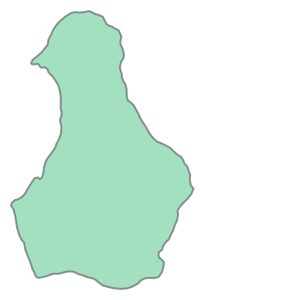

In [41]:
gpd_read.geometry.iloc[2]